In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import cactas as C
import os
import mahotas as mh
import nibabel as nib
import nrrd
import skimage.morphology
import cv2
from skimage.filters import threshold_otsu

In [3]:
import tensorflow as tf
gpu_available = tf.test.is_gpu_available()
gpu_available

2024-05-05 12:02:12.884285: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2024-05-05 12:02:15.330797: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-05 12:02:15.333040: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-05-05 12:02:15.726809: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:47:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-05 12:02:15.729581: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:4e:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 3

True

In [4]:
DATAPATH='/raid/mpsych/CACTAS/DATA/ESUS'
CAPATH='/raid/mpsych/CACTAS/DATA/CA24'

In [5]:
images, labels = C.Helper.load_data(DATAPATH)

In [6]:
masks = C.Helper.load_seg_data(CAPATH)

In [7]:
X_train, y_train, m_train, X_test, y_test, m_test = C.Helper.split_patients_masks(images, labels, masks)

In [8]:
X_train, y_train, m_train, X_test, y_test, m_test = C.Helper.normalization2(DATAPATH, CAPATH, X_train, y_train, m_train, X_test, y_test, m_test)

In [9]:
slice_to_patient_mapping, last_key = C.Helper.map_and_key(y_train)

In [10]:
X_train, y_train, X_test, y_test = C.Helper.extract_slices(X_train, y_train, X_test, y_test)

(12973, 512, 512, 1) (12973, 512, 512, 1) (3793, 512, 512, 1) (3793, 512, 512, 1)


In [11]:
m_train, m_test = C.Helper.extract_masks_slices(m_train, m_test)

(12973, 512, 512, 1) (3793, 512, 512, 1)


In [12]:
X_train, y_train, m_train = C.Helper.filter_slices(X_train, y_train, m_train)

(561, 512, 512, 1) (561, 512, 512, 1) (561, 512, 512, 1)


In [13]:
X_train.dtype, y_train.dtype, X_test.dtype, y_test.dtype

(dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'))

In [14]:
m_train.dtype

dtype('float64')

In [15]:
train_masks=[]
for i in range(len(m_train)):
    binary = (m_train[i] > 0).astype(np.uint8)
    train_masks.append(binary)

In [16]:
train_images=[]
for i in range(len(X_train)):
    train_image = X_train[i] * train_masks[i]
    train_images.append(train_image)
train_images_array = np.array(train_images)

In [17]:
#train_images_array = train_images_array.astype(np.float32)

In [18]:
train_images_array = train_images_array.reshape(train_images_array.shape[0], train_images_array.shape[1],train_images_array.shape[2], 1)

In [19]:
# for i in range(10, 20):
#     plt.imshow(train_images[i])
#     plt.show()

In [20]:
# for i in range(10, 20):
#     plt.imshow(train_images[i])
#     plt.imshow(y_train[i], cmap='gray', alpha=0.5)
#     plt.show()

In [21]:
# fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# axes[0].imshow(X_train[10], vmin=0, vmax=1)
# axes[0].set_title('Original Image')
# axes[1].imshow(train_masks[10])
# axes[1].set_title('Mask')
# axes[2].imshow(train_images[10])
# axes[2].set_title('Processed Image')
# plt.show()

In [22]:
test_masks=[]
for i in range(len(m_test)):
    binary = (m_test[i] > 0).astype(np.uint8)
    test_masks.append(binary)

In [23]:
test_images=[]
for i in range(len(X_test)):
    test_image = X_test[i] * test_masks[i]
    test_images.append(test_image)
test_images_array = np.array(test_images)

In [24]:
#test_images_array = test_images_array.astype(np.float32)

In [25]:
test_images_array = test_images_array.reshape(test_images_array.shape[0], test_images_array.shape[1],test_images_array.shape[2], 1)

In [26]:
X_train_set = train_images_array[:last_key]
y_train_set = y_train[:last_key]
X_val = train_images_array[last_key:]
y_val = y_train[last_key:]

In [27]:
#y_train_set = y_train_set.astype(np.float32)

In [28]:
#y_val = y_val.astype(np.float32)

In [29]:
X_train_set.dtype, y_train_set.dtype

(dtype('float64'), dtype('float64'))

In [30]:
X_val.dtype, y_val.dtype

(dtype('float64'), dtype('float64'))

In [31]:
test_images_array.dtype, y_test.dtype

(dtype('float64'), dtype('float64'))

In [32]:
X_val.shape, y_val.shape

((116, 512, 512, 1), (116, 512, 512, 1))

In [33]:
model = C.Helper.create_unet(X_train_set[0].shape)

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


2024-05-05 12:05:29.172415: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:47:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-05 12:05:29.175015: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:4e:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-05 12:05:29.185015: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0, 1
2024-05-05 12:05:29.187986: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:47:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-05 12:05:29.190449: I tensorflow/core

In [34]:
model, history = C.Helper.train_unet(X_train_set, y_train_set, X_val, y_val, model, epochs=500)

2024-05-05 12:05:30.199233: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2024-05-05 12:05:30.201218: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245740000 Hz


Epoch 1/500


2024-05-05 12:05:31.545184: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-05-05 12:05:32.516002: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2024-05-05 12:05:33.554111: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2024-05-05 12:05:33.554135: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2024-05-05 12:05:33.554492: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-05-05 12:05:33.652178: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-05-05 12:05:34.671393: I tensorflow/stream_exec

13/13 [==============================] - 43s 2s/step - loss: 0.4424 - iou: 2.3486e-04 - iou_thresholded: 7.0391e-04 - val_loss: 0.0193 - val_iou: 6.5686e-04 - val_iou_thresholded: 7.0441e-04
Epoch 2/500


2024-05-05 12:06:20.995768: W tensorflow/core/common_runtime/bfc_allocator.cc:271] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.64GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


13/13 [==============================] - 28s 1s/step - loss: 0.0089 - iou: 2.7534e-04 - iou_thresholded: 7.8149e-04 - val_loss: 0.0038 - val_iou: 4.6090e-04 - val_iou_thresholded: 7.0441e-04
Epoch 3/500
13/13 [==============================] - 13s 1s/step - loss: 0.0020 - iou: 0.0010 - iou_thresholded: 8.3250e-04 - val_loss: 0.0017 - val_iou: 0.0052 - val_iou_thresholded: 7.0441e-04
Epoch 4/500
13/13 [==============================] - 13s 1s/step - loss: 0.0010 - iou: 0.0078 - iou_thresholded: 8.0522e-04 - val_loss: 0.0017 - val_iou: 0.0147 - val_iou_thresholded: 7.0441e-04
Epoch 5/500
13/13 [==============================] - 13s 1s/step - loss: 0.0010 - iou: 0.0149 - iou_thresholded: 7.6429e-04 - val_loss: 0.0015 - val_iou: 0.0172 - val_iou_thresholded: 7.0441e-04
Epoch 6/500
13/13 [==============================] - 13s 1s/step - loss: 8.8598e-04 - iou: 0.0163 - iou_thresholded: 7.7367e-04 - val_loss: 0.0015 - val_iou: 0.0212 - val_iou_thresholded: 7.0441e-04
Epoch 7/500
13/13 [======

13/13 [==============================] - 13s 1s/step - loss: 2.9449e-04 - iou: 0.3936 - iou_thresholded: 0.5151 - val_loss: 0.0013 - val_iou: 0.3446 - val_iou_thresholded: 0.4135
Epoch 45/500
13/13 [==============================] - 13s 1s/step - loss: 2.8934e-04 - iou: 0.4130 - iou_thresholded: 0.5423 - val_loss: 0.0013 - val_iou: 0.2998 - val_iou_thresholded: 0.3329
Epoch 46/500
13/13 [==============================] - 13s 1s/step - loss: 2.7923e-04 - iou: 0.4061 - iou_thresholded: 0.5267 - val_loss: 0.0012 - val_iou: 0.2969 - val_iou_thresholded: 0.4012
Epoch 47/500
13/13 [==============================] - 13s 1s/step - loss: 2.8128e-04 - iou: 0.4189 - iou_thresholded: 0.5427 - val_loss: 0.0013 - val_iou: 0.2999 - val_iou_thresholded: 0.4015
Epoch 48/500
13/13 [==============================] - 13s 1s/step - loss: 2.8887e-04 - iou: 0.4027 - iou_thresholded: 0.5188 - val_loss: 0.0012 - val_iou: 0.3026 - val_iou_thresholded: 0.4611
Epoch 49/500
13/13 [==============================] -

Epoch 87/500
13/13 [==============================] - 13s 1s/step - loss: 1.6206e-04 - iou: 0.6175 - iou_thresholded: 0.7190 - val_loss: 0.0019 - val_iou: 0.4063 - val_iou_thresholded: 0.4548
Epoch 88/500
13/13 [==============================] - 13s 1s/step - loss: 1.3880e-04 - iou: 0.6329 - iou_thresholded: 0.7285 - val_loss: 0.0018 - val_iou: 0.3946 - val_iou_thresholded: 0.4447
Epoch 89/500
13/13 [==============================] - 13s 1s/step - loss: 1.4350e-04 - iou: 0.6433 - iou_thresholded: 0.7380 - val_loss: 0.0019 - val_iou: 0.3837 - val_iou_thresholded: 0.4360
Epoch 90/500
13/13 [==============================] - 13s 1s/step - loss: 1.3293e-04 - iou: 0.6289 - iou_thresholded: 0.7261 - val_loss: 0.0024 - val_iou: 0.3927 - val_iou_thresholded: 0.4272
Epoch 91/500
13/13 [==============================] - 13s 1s/step - loss: 1.4757e-04 - iou: 0.6489 - iou_thresholded: 0.7445 - val_loss: 0.0021 - val_iou: 0.3663 - val_iou_thresholded: 0.3895
Epoch 92/500
13/13 [====================

13/13 [==============================] - 13s 1s/step - loss: 9.5375e-05 - iou: 0.7309 - iou_thresholded: 0.8110 - val_loss: 0.0028 - val_iou: 0.3972 - val_iou_thresholded: 0.4211
Epoch 130/500
13/13 [==============================] - 13s 1s/step - loss: 1.0120e-04 - iou: 0.7186 - iou_thresholded: 0.8029 - val_loss: 0.0027 - val_iou: 0.3841 - val_iou_thresholded: 0.4042
Epoch 131/500
13/13 [==============================] - 13s 1s/step - loss: 1.1674e-04 - iou: 0.7028 - iou_thresholded: 0.7771 - val_loss: 0.0027 - val_iou: 0.3831 - val_iou_thresholded: 0.4176
Epoch 132/500
13/13 [==============================] - 13s 1s/step - loss: 1.1311e-04 - iou: 0.7188 - iou_thresholded: 0.8011 - val_loss: 0.0022 - val_iou: 0.3984 - val_iou_thresholded: 0.4354
Epoch 133/500
13/13 [==============================] - 13s 1s/step - loss: 9.9691e-05 - iou: 0.7332 - iou_thresholded: 0.8167 - val_loss: 0.0024 - val_iou: 0.4118 - val_iou_thresholded: 0.4348
Epoch 134/500
13/13 [============================

13/13 [==============================] - 13s 1s/step - loss: 6.8204e-05 - iou: 0.8149 - iou_thresholded: 0.8881 - val_loss: 0.0044 - val_iou: 0.4031 - val_iou_thresholded: 0.4152
Epoch 172/500
13/13 [==============================] - 13s 1s/step - loss: 6.2377e-05 - iou: 0.8466 - iou_thresholded: 0.9015 - val_loss: 0.0043 - val_iou: 0.4106 - val_iou_thresholded: 0.4196
Epoch 173/500
13/13 [==============================] - 13s 1s/step - loss: 6.4915e-05 - iou: 0.8380 - iou_thresholded: 0.9006 - val_loss: 0.0048 - val_iou: 0.3936 - val_iou_thresholded: 0.4056
Epoch 174/500
13/13 [==============================] - 13s 1s/step - loss: 6.3041e-05 - iou: 0.8352 - iou_thresholded: 0.8910 - val_loss: 0.0049 - val_iou: 0.3982 - val_iou_thresholded: 0.4093
Epoch 175/500
13/13 [==============================] - 13s 1s/step - loss: 7.2545e-05 - iou: 0.8299 - iou_thresholded: 0.8886 - val_loss: 0.0041 - val_iou: 0.4161 - val_iou_thresholded: 0.4317
Epoch 176/500
13/13 [============================

13/13 [==============================] - 13s 1s/step - loss: 4.5337e-05 - iou: 0.8976 - iou_thresholded: 0.9482 - val_loss: 0.0059 - val_iou: 0.4099 - val_iou_thresholded: 0.4197
Epoch 214/500
13/13 [==============================] - 13s 1s/step - loss: 4.8262e-05 - iou: 0.9078 - iou_thresholded: 0.9452 - val_loss: 0.0059 - val_iou: 0.4286 - val_iou_thresholded: 0.4357
Epoch 215/500
13/13 [==============================] - 13s 1s/step - loss: 3.0730e-05 - iou: 0.9160 - iou_thresholded: 0.9572 - val_loss: 0.0056 - val_iou: 0.4407 - val_iou_thresholded: 0.4501
Epoch 216/500
13/13 [==============================] - 13s 1s/step - loss: 5.5164e-05 - iou: 0.9070 - iou_thresholded: 0.9490 - val_loss: 0.0058 - val_iou: 0.4220 - val_iou_thresholded: 0.4344
Epoch 217/500
13/13 [==============================] - 13s 1s/step - loss: 2.2460e-05 - iou: 0.9359 - iou_thresholded: 0.9713 - val_loss: 0.0065 - val_iou: 0.4208 - val_iou_thresholded: 0.4255
Epoch 218/500
13/13 [============================

13/13 [==============================] - 13s 1s/step - loss: 3.6375e-05 - iou: 0.9362 - iou_thresholded: 0.9638 - val_loss: 0.0066 - val_iou: 0.4270 - val_iou_thresholded: 0.4352
Epoch 256/500
13/13 [==============================] - 13s 1s/step - loss: 3.4443e-05 - iou: 0.9395 - iou_thresholded: 0.9679 - val_loss: 0.0065 - val_iou: 0.4080 - val_iou_thresholded: 0.4198
Epoch 257/500
13/13 [==============================] - 13s 1s/step - loss: 3.5161e-05 - iou: 0.9409 - iou_thresholded: 0.9717 - val_loss: 0.0068 - val_iou: 0.4157 - val_iou_thresholded: 0.4218
Epoch 258/500
13/13 [==============================] - 13s 1s/step - loss: 2.9418e-05 - iou: 0.9467 - iou_thresholded: 0.9721 - val_loss: 0.0068 - val_iou: 0.4061 - val_iou_thresholded: 0.4140
Epoch 259/500
13/13 [==============================] - 13s 1s/step - loss: 4.2495e-05 - iou: 0.9347 - iou_thresholded: 0.9660 - val_loss: 0.0070 - val_iou: 0.4006 - val_iou_thresholded: 0.4112
Epoch 260/500
13/13 [============================

13/13 [==============================] - 13s 1s/step - loss: 3.1520e-05 - iou: 0.9610 - iou_thresholded: 0.9772 - val_loss: 0.0071 - val_iou: 0.4159 - val_iou_thresholded: 0.4207
Epoch 298/500
13/13 [==============================] - 13s 1s/step - loss: 3.4155e-05 - iou: 0.9510 - iou_thresholded: 0.9760 - val_loss: 0.0072 - val_iou: 0.4218 - val_iou_thresholded: 0.4324
Epoch 299/500
13/13 [==============================] - 13s 1s/step - loss: 1.5544e-05 - iou: 0.9673 - iou_thresholded: 0.9869 - val_loss: 0.0078 - val_iou: 0.4243 - val_iou_thresholded: 0.4270
Epoch 300/500
13/13 [==============================] - 13s 1s/step - loss: 3.0654e-05 - iou: 0.9604 - iou_thresholded: 0.9823 - val_loss: 0.0083 - val_iou: 0.4083 - val_iou_thresholded: 0.4143
Epoch 301/500
13/13 [==============================] - 13s 1s/step - loss: 3.9605e-05 - iou: 0.9531 - iou_thresholded: 0.9738 - val_loss: 0.0077 - val_iou: 0.4303 - val_iou_thresholded: 0.4387
Epoch 302/500
13/13 [============================

13/13 [==============================] - 13s 1s/step - loss: 3.7493e-05 - iou: 0.9542 - iou_thresholded: 0.9762 - val_loss: 0.0081 - val_iou: 0.3939 - val_iou_thresholded: 0.4027
Epoch 340/500
13/13 [==============================] - 13s 1s/step - loss: 2.9351e-05 - iou: 0.9605 - iou_thresholded: 0.9809 - val_loss: 0.0079 - val_iou: 0.4126 - val_iou_thresholded: 0.4185
Epoch 341/500
13/13 [==============================] - 13s 1s/step - loss: 1.6373e-05 - iou: 0.9762 - iou_thresholded: 0.9883 - val_loss: 0.0088 - val_iou: 0.4123 - val_iou_thresholded: 0.4147
Epoch 342/500
13/13 [==============================] - 13s 1s/step - loss: 2.7506e-05 - iou: 0.9690 - iou_thresholded: 0.9837 - val_loss: 0.0082 - val_iou: 0.4304 - val_iou_thresholded: 0.4352
Epoch 343/500
13/13 [==============================] - 13s 1s/step - loss: 2.7847e-05 - iou: 0.9603 - iou_thresholded: 0.9826 - val_loss: 0.0087 - val_iou: 0.4087 - val_iou_thresholded: 0.4128
Epoch 344/500
13/13 [============================

13/13 [==============================] - 13s 1s/step - loss: 2.9896e-05 - iou: 0.9656 - iou_thresholded: 0.9818 - val_loss: 0.0074 - val_iou: 0.4265 - val_iou_thresholded: 0.4358
Epoch 382/500
13/13 [==============================] - 13s 1s/step - loss: 2.1611e-05 - iou: 0.9650 - iou_thresholded: 0.9843 - val_loss: 0.0080 - val_iou: 0.4301 - val_iou_thresholded: 0.4355
Epoch 383/500
13/13 [==============================] - 13s 1s/step - loss: 3.2523e-05 - iou: 0.9647 - iou_thresholded: 0.9822 - val_loss: 0.0087 - val_iou: 0.4293 - val_iou_thresholded: 0.4331
Epoch 384/500
13/13 [==============================] - 13s 1s/step - loss: 3.8116e-05 - iou: 0.9535 - iou_thresholded: 0.9773 - val_loss: 0.0086 - val_iou: 0.4200 - val_iou_thresholded: 0.4286
Epoch 385/500
13/13 [==============================] - 13s 1s/step - loss: 1.8572e-05 - iou: 0.9720 - iou_thresholded: 0.9878 - val_loss: 0.0085 - val_iou: 0.4282 - val_iou_thresholded: 0.4337
Epoch 386/500
13/13 [============================

13/13 [==============================] - 13s 1s/step - loss: 1.6317e-05 - iou: 0.9824 - iou_thresholded: 0.9902 - val_loss: 0.0077 - val_iou: 0.4267 - val_iou_thresholded: 0.4315
Epoch 424/500
13/13 [==============================] - 13s 1s/step - loss: 3.1749e-05 - iou: 0.9579 - iou_thresholded: 0.9817 - val_loss: 0.0088 - val_iou: 0.4349 - val_iou_thresholded: 0.4364
Epoch 425/500
13/13 [==============================] - 13s 1s/step - loss: 2.4909e-05 - iou: 0.9662 - iou_thresholded: 0.9825 - val_loss: 0.0089 - val_iou: 0.4273 - val_iou_thresholded: 0.4312
Epoch 426/500
13/13 [==============================] - 13s 1s/step - loss: 4.1592e-05 - iou: 0.9508 - iou_thresholded: 0.9715 - val_loss: 0.0089 - val_iou: 0.4231 - val_iou_thresholded: 0.4304
Epoch 427/500
13/13 [==============================] - 13s 1s/step - loss: 1.9358e-05 - iou: 0.9692 - iou_thresholded: 0.9837 - val_loss: 0.0092 - val_iou: 0.4147 - val_iou_thresholded: 0.4187
Epoch 428/500
13/13 [============================

13/13 [==============================] - 13s 1s/step - loss: 2.5686e-05 - iou: 0.9781 - iou_thresholded: 0.9851 - val_loss: 0.0078 - val_iou: 0.4262 - val_iou_thresholded: 0.4363
Epoch 466/500
13/13 [==============================] - 13s 1s/step - loss: 3.0860e-05 - iou: 0.9575 - iou_thresholded: 0.9799 - val_loss: 0.0085 - val_iou: 0.4333 - val_iou_thresholded: 0.4374
Epoch 467/500
13/13 [==============================] - 13s 1s/step - loss: 2.2372e-05 - iou: 0.9766 - iou_thresholded: 0.9883 - val_loss: 0.0085 - val_iou: 0.4304 - val_iou_thresholded: 0.4355
Epoch 468/500
13/13 [==============================] - 13s 1s/step - loss: 3.6534e-05 - iou: 0.9633 - iou_thresholded: 0.9807 - val_loss: 0.0074 - val_iou: 0.4415 - val_iou_thresholded: 0.4491
Epoch 469/500
13/13 [==============================] - 13s 1s/step - loss: 1.7158e-05 - iou: 0.9746 - iou_thresholded: 0.9890 - val_loss: 0.0079 - val_iou: 0.4473 - val_iou_thresholded: 0.4494
Epoch 470/500
13/13 [============================

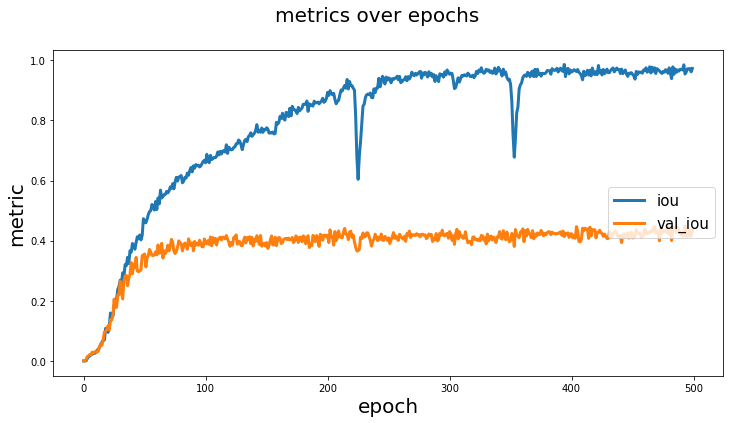

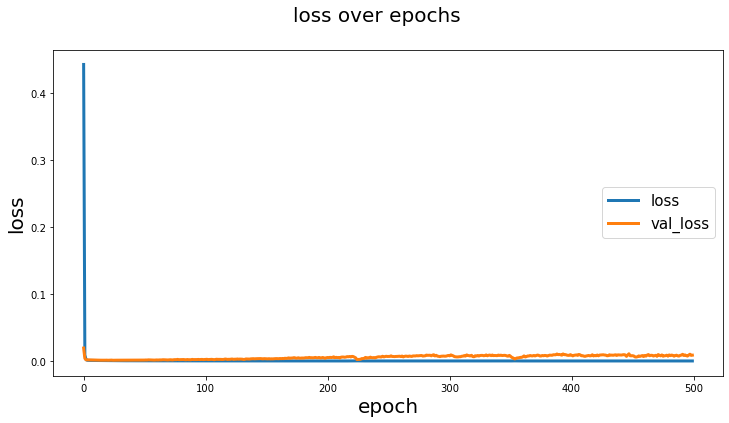

In [35]:
C.Helper.visualize_graph(history)

In [36]:
y_pred = C.Helper.prediction(test_images_array, model)

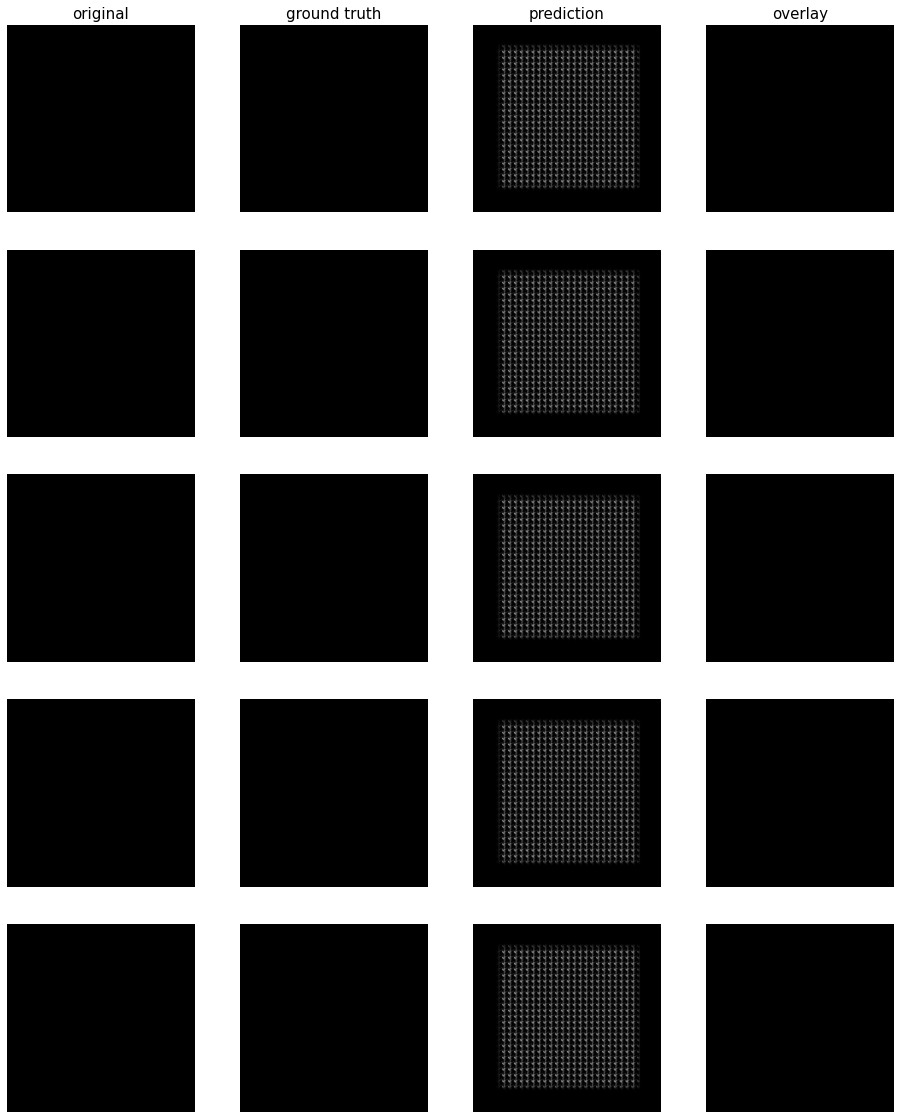

In [37]:
C.Helper.visualize_result(test_images_array, y_test, y_pred)

In [38]:
C.Helper.evaluate(test_images_array, y_test, model)

119/119 [==============================] - 26s 222ms/step - loss: 6.9760e-04 - iou: 0.1165 - iou_thresholded: 0.5421
